Author: Nelson Liu

Email: [nliu@uncharted.software](mailto:nliu@uncharted.software)

# Typing Example

Example use case for multi-stratification with multiple node types:

1. SIRV `x` Age = SIRV_Age
2. SIRV_Age `x` Travel = SIRV_Age_Travel

SIRV: SIR compartmental model with vaccination and vaccine production
Age: Age-group contact model
Travel: Travel model

In [32]:
# Libraries
using AlgebraicPetri, AlgebraicPetri.TypedPetri
using Catlab.Programs, Catlab.Graphics
using Catlab.CategoricalAlgebra
using GraphViz

In [33]:
using Pkg
# Pkg.dependencies()
Pkg.installed()
# Pkg.status("AlgebraicPetri")

┌ Warning: Pkg.installed() is deprecated
└ @ Pkg /cache/build/default-amdci4-2/julialang/julia-release-1-dot-8/usr/share/julia/stdlib/v1.8/Pkg/src/Pkg.jl:675


Dict{String, VersionNumber} with 9 entries:
  "AlgebraicPetri"        => v"0.8.11"
  "DifferentialEquations" => v"7.7.0"
  "IJulia"                => v"1.24.0"
  "Plots"                 => v"1.38.12"
  "Catlab"                => v"0.14.17"
  "GraphViz"              => v"0.2.0"
  "ModelingToolkit"       => v"8.55.1"
  "Latexify"              => v"0.16.0"
  "EasyModelAnalysis"     => v"0.1.9"

## Define Ontology

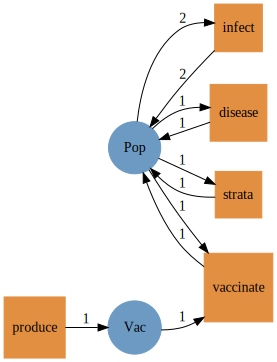

In [34]:
const ontology = LabelledPetriNet(
    [:Pop, :Vac],
    :infect => ((:Pop, :Pop) => (:Pop, :Pop)),
    :disease => (:Pop => :Pop),
    :strata => (:Pop => :Pop),
    :vaccinate => ((:Pop, :Vac) => :Pop),
    :produce => (() => :Vac),
)

Graph(ontology)

## Define Base Models

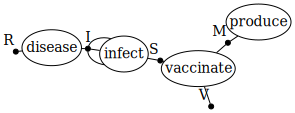

In [35]:
# SIR model with vaccine production and vaccination interactions
sirv_uwd = @relation () where (S::Pop, I::Pop, R::Pop, M::Vac, V::Pop) begin
    infect(S, I, I, I)
    disease(I, R)
    vaccinate(S, M, V)
    produce(M)
end

to_graphviz(sirv_uwd, box_labels = :name, junction_labels = :variable)

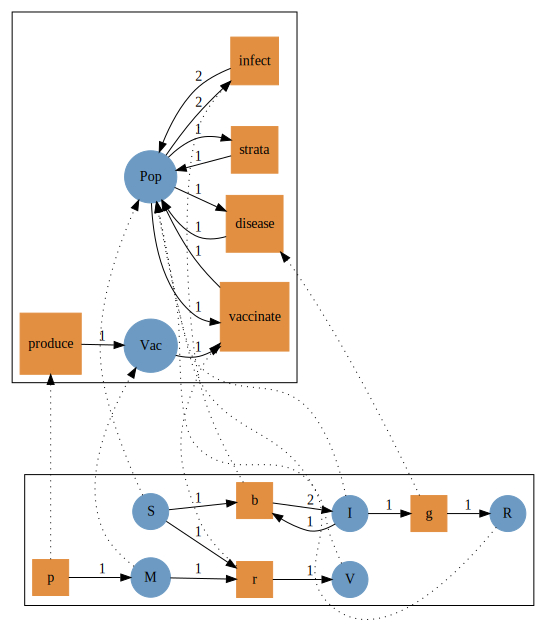

In [36]:
tnames = [:b, :g, :r, :p]
typed_sirv = oapply_typed(ontology, sirv_uwd, tnames)
Graph(typed_sirv)

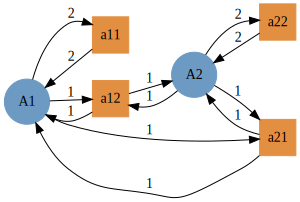

In [37]:
# Age-group infection/contact model
N = 2
# snames = [Symbol("A$i") for i in 1:N]
# typed_age = pairwise_id_typed_petri(ontology, :Pop, :infect, snames)
age_uwd = @relation () where (A1::Pop, A2::Pop) begin
    infect(A1, A1, A1, A1)
    infect(A1, A2, A1, A2)
    infect(A2, A1, A2, A1)
    infect(A2, A2, A2, A2)
end
tnames = [:a11, :a12, :a21, :a22]
typed_age = oapply_typed(ontology, age_uwd, tnames)

Graph(dom(typed_age))


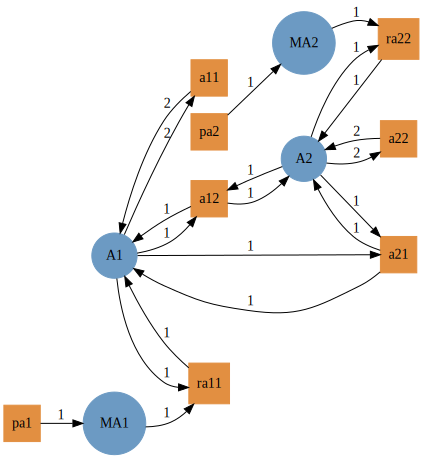

In [38]:

# ^ Not sufficient, need to include "vaccinate" and "produce" interactions to correctly stratify with SIRV
agev_uwd = @relation () where (A1::Pop, A2::Pop, MA1::Vac, MA2::Vac) begin
    infect(A1, A1, A1, A1)
    infect(A1, A2, A1, A2)
    infect(A2, A1, A2, A1)
    infect(A2, A2, A2, A2)
    vaccinate(A1, MA1, A1)
    vaccinate(A2, MA2, A2)
    produce(MA1)
    produce(MA2)
end
tnames = [:a11, :a12, :a21, :a22, :ra11, :ra22, :pa1, :pa2]
typed_agev = oapply_typed(ontology, agev_uwd, tnames)

Graph(dom(typed_agev))

## Stratification

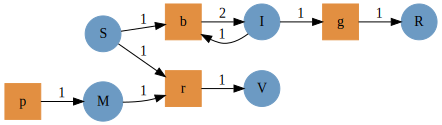

In [39]:
# Augment SIRV model
typed_sirv_aug = add_reflexives(
    typed_sirv,
    [[], [], [], [], []],
    ontology
)

Graph(dom(typed_sirv_aug))

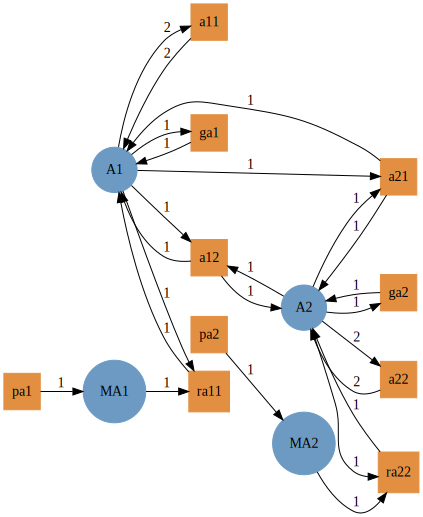

In [40]:
# Augment age (contact) model
# Permit all age states to have a "disease" self-interaction
# typed_agev_aug = add_reflexives(
#     typed_agev,
#     [[:disease], [:disease], [], [], []],
#     ontology
# )

# Define from scratch to add non-trivial self-interactions (e.g. `vaccinate`)
agev_aug_uwd = @relation () where (A1::Pop, A2::Pop, MA1::Vac, MA2::Vac) begin
    infect(A1, A1, A1, A1)
    infect(A1, A2, A1, A2)
    infect(A2, A1, A2, A1)
    infect(A2, A2, A2, A2)
    vaccinate(A1, MA1, A1)
    vaccinate(A2, MA2, A2)
    produce(MA1)
    produce(MA2)
    disease(A1, A1)
    disease(A2, A2)
end
tnames = [:a11, :a12, :a21, :a22, :ra11, :ra22, :pa1, :pa2, :ga1, :ga2]
typed_agev_aug = oapply_typed(ontology, agev_aug_uwd, tnames)


# Graph(dom(typed_age_aug))
Graph(dom(typed_agev_aug))

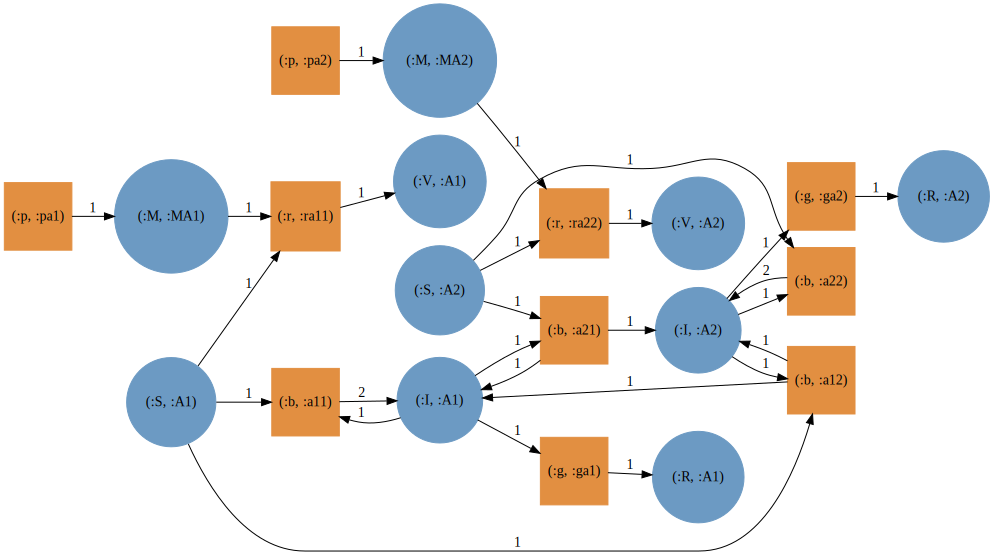

In [41]:
# Stratify SIRV and AgeV models
typed_sirv_agev = typed_product(typed_sirv_aug, typed_agev_aug)

Graph(dom(typed_sirv_agev))

## Define Next Strata Model

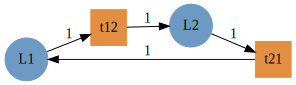

In [42]:
# 2-Location Travel model
# Allow self-interaction

# N = 2
# snames = [Symbol("L$i") for i in 1:N]
# typed_age = pairwise_id_typed_petri(ontology, :Pop, :strata, snames)

travel_uwd = @relation () where (L1::Pop, L2::Pop) begin
    strata(L1, L2)
    strata(L2, L1)
end
tnames = [:t12, :t21]
typed_travel = oapply_typed(ontology, travel_uwd, tnames)

Graph(dom(typed_travel))

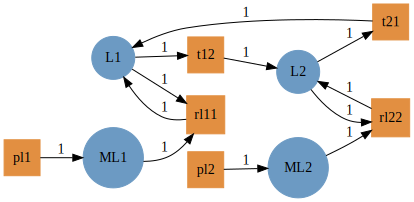

In [43]:
# Not enough, need to include `vaccinate` and `produce` self-interactions

travelv_uwd = @relation () where (L1::Pop, L2::Pop, ML1::Vac, ML2::Vac) begin
    strata(L1, L2)
    strata(L2, L1)
    vaccinate(L1, ML1, L1)
    vaccinate(L2, ML2, L2)
    produce(ML1)
    produce(ML2)
end
tnames = [:t12, :t21, :rl11, :rl22, :pl1, :pl2]
typed_travelv = oapply_typed(ontology, travelv_uwd, tnames)

Graph(dom(typed_travelv))

## Second Stratification

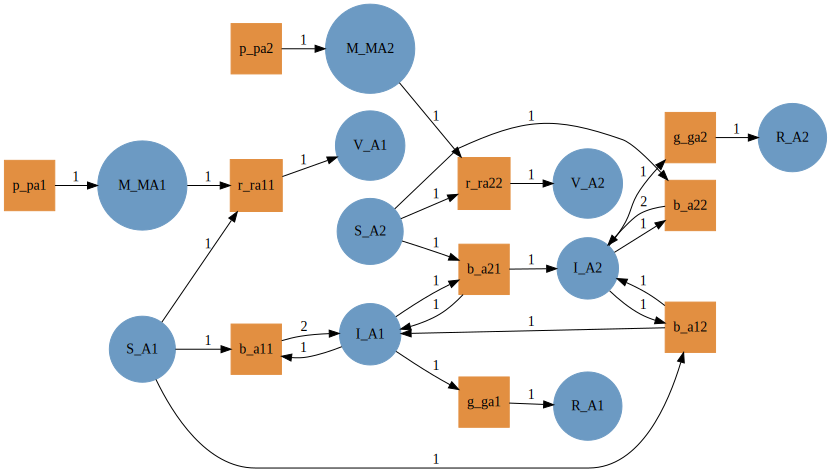

In [44]:
# Flatten labels to permit addition of reflexives
typed_sirv_agev_flat = flatten_labels(typed_sirv_agev)

Graph(dom(typed_sirv_agev_flat))

In [45]:
# dom(typed_sirv_agev_flat)
# dom(typed_sirv_agev_flat)[:tname]
dom(typed_sirv_agev_flat)[:sname]

# ^ can be used to rename
# dom(typed_sirv_agev_flat)[:tname][11] = :TESTING

10-element Catlab.Columns.ColumnView{Int64, Symbol, Catlab.ColumnImplementations.DenseColumn{Symbol, Vector{Symbol}}, UnitRange{Int64}, Nothing}:
 :S_A1
 :I_A1
 :R_A1
 :V_A1
 :S_A2
 :I_A2
 :R_A2
 :V_A2
 :M_MA1
 :M_MA2

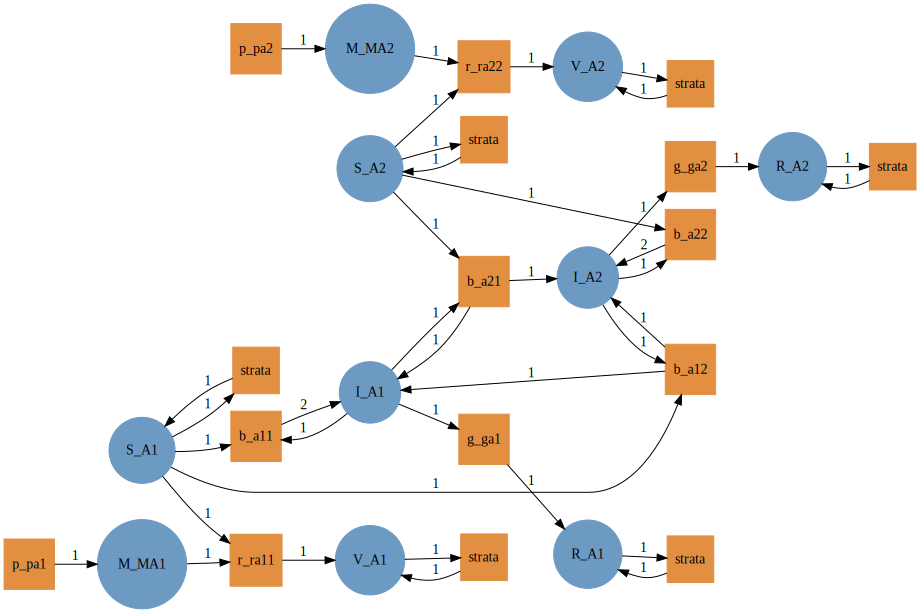

In [46]:
# Augment first stratified model with `strata` self-interactions
# i.e. allow all `Pop` to travel

typed_sirv_agev_flat_aug = add_reflexives(
    typed_sirv_agev_flat,
    [[:strata], [], [:strata], [:strata], [:strata], [], [:strata], [:strata], [], []],
    ontology
)

Graph(dom(typed_sirv_agev_flat_aug))

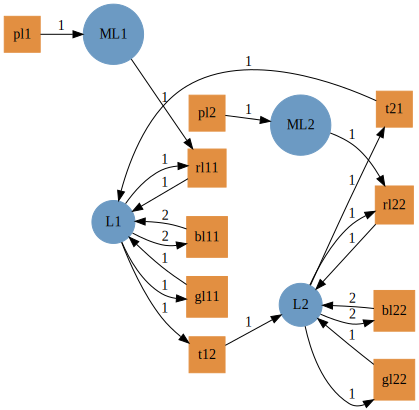

In [47]:
# Augment travel model with self-interactions (`infect`, `disease`)
# i.e. local infections and recoveries only (no non-local interactions)


# typed_travelv_aug = add_reflexives(
#     typed_travelv,
#     [[:infect, :disease], [:infect, :disease]],
#     ontology
# )

# Define from scratch to add non-trivial self-interactions (e.g. `vaccinate`)
travelv_aug_uwd = @relation () where (L1::Pop, L2::Pop, ML1::Vac, ML2::Vac) begin
    strata(L1, L2)
    strata(L2, L1)
    vaccinate(L1, ML1, L1)
    vaccinate(L2, ML2, L2)
    produce(ML1)
    produce(ML2)
    infect(L1, L1, L1, L1)
    infect(L2, L2, L2, L2)
    disease(L1, L1)
    disease(L2, L2)
end
tnames = [:t12, :t21, :rl11, :rl22, :pl1, :pl2, :bl11, :bl22, :gl11, :gl22]
typed_travelv_aug = oapply_typed(ontology, travelv_aug_uwd, tnames)


Graph(dom(typed_travelv_aug))

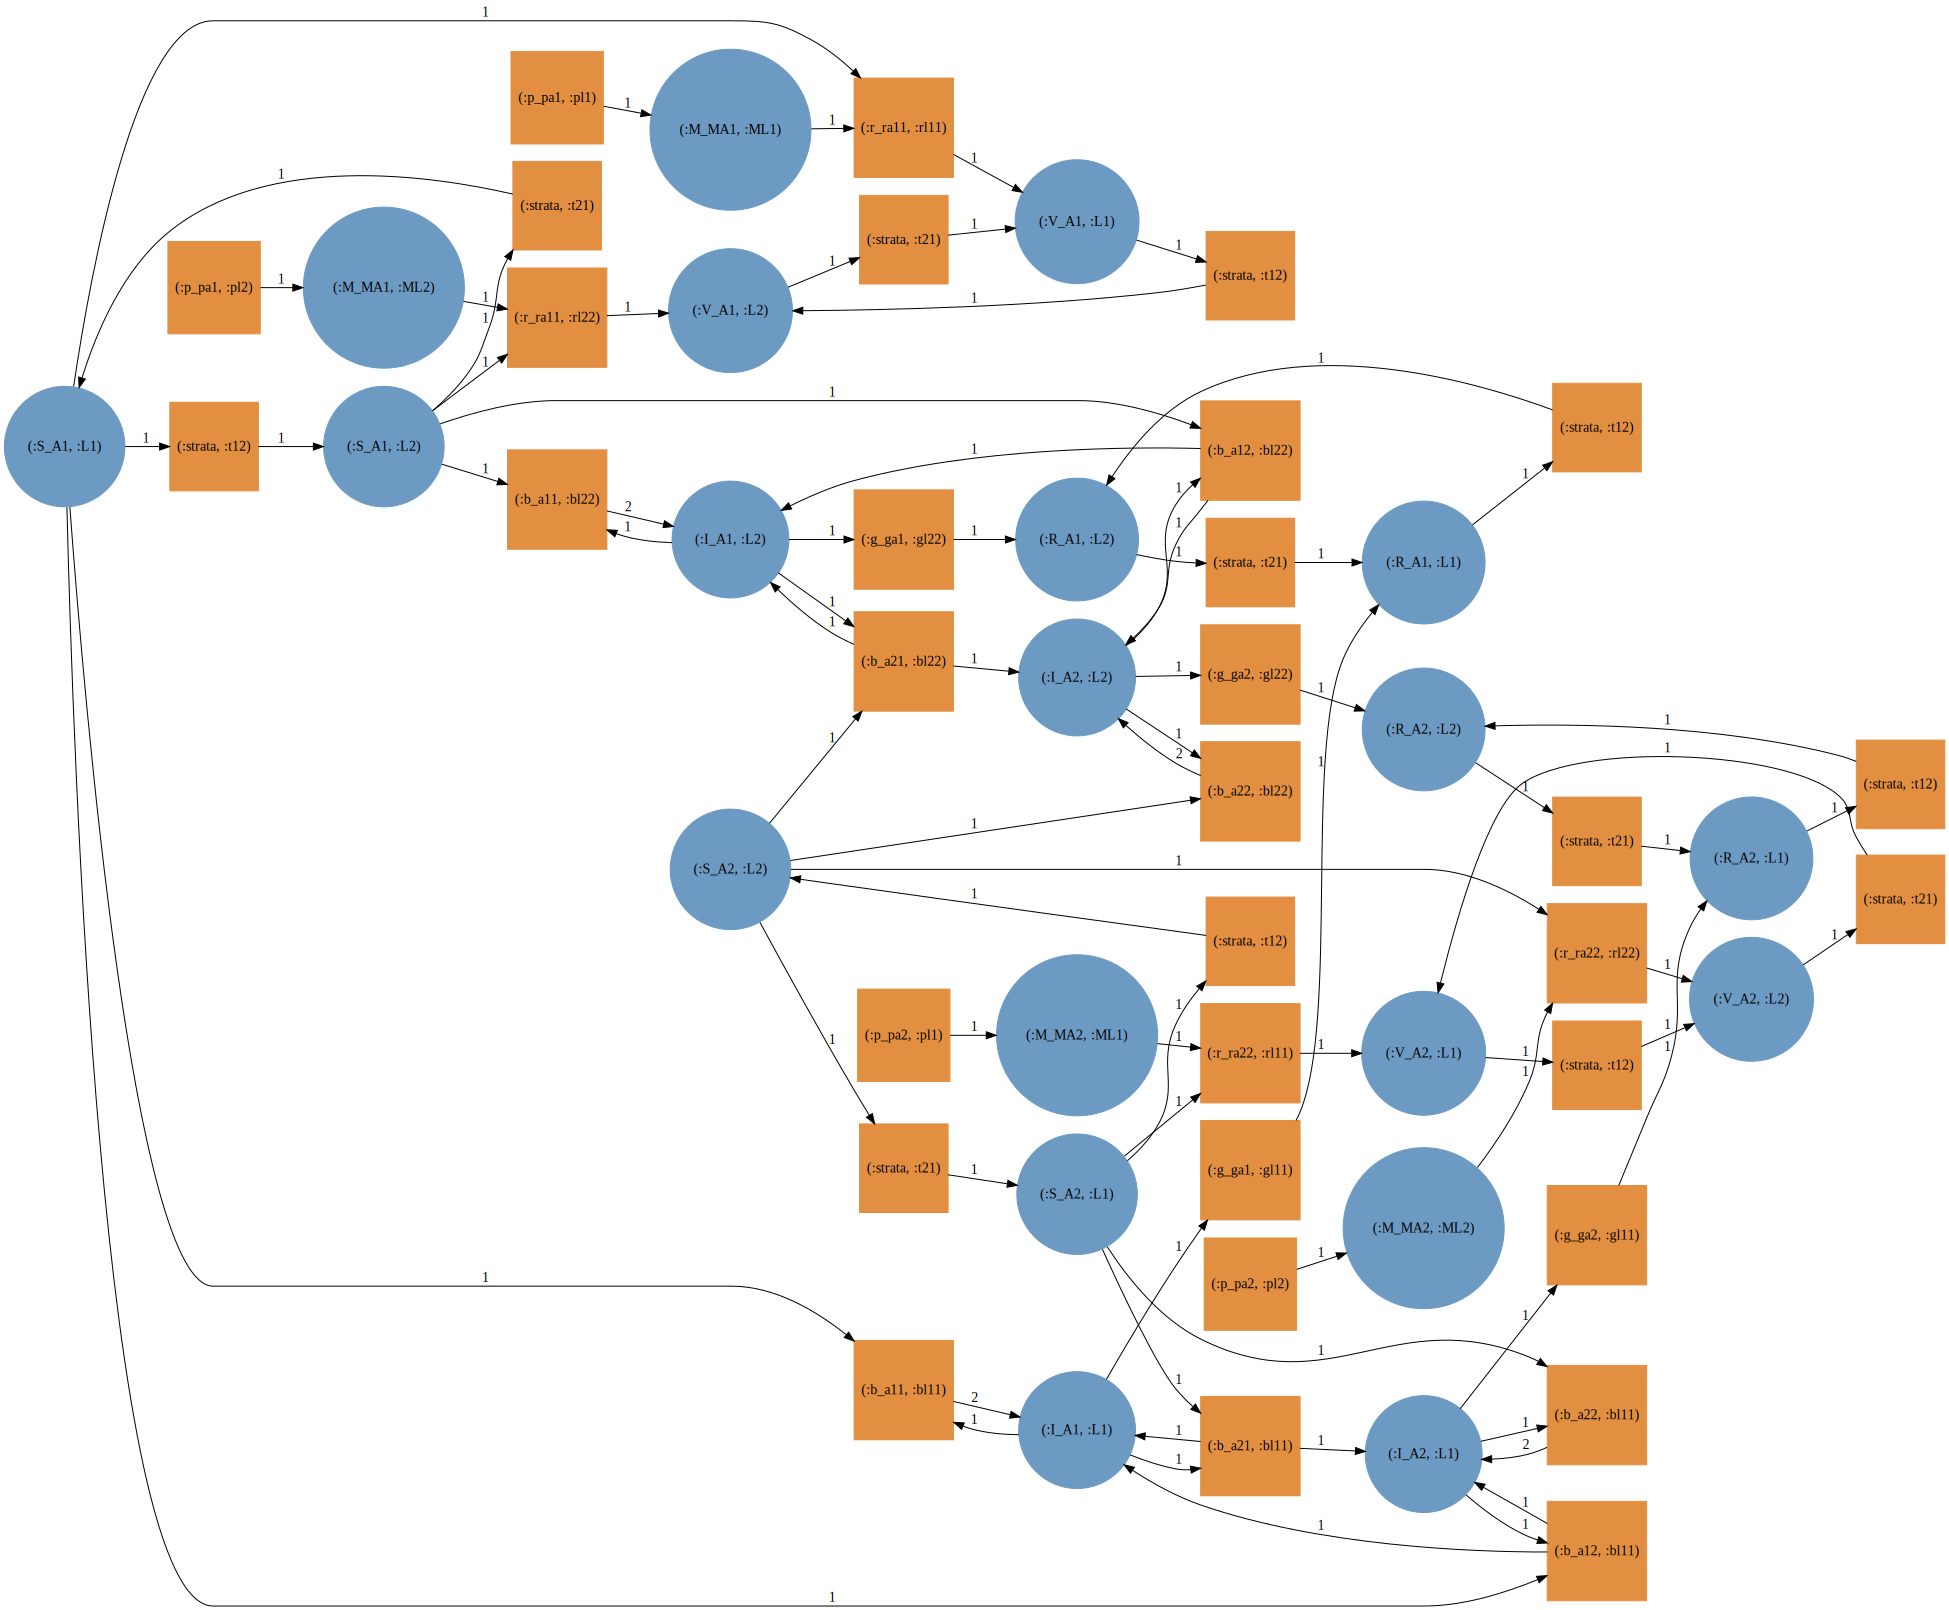

In [48]:
# Stratify the two augmented models
typed_sirv_agev_travelv = typed_product(typed_sirv_agev_flat_aug, typed_travelv_aug)

Graph(dom(typed_sirv_agev_travelv))

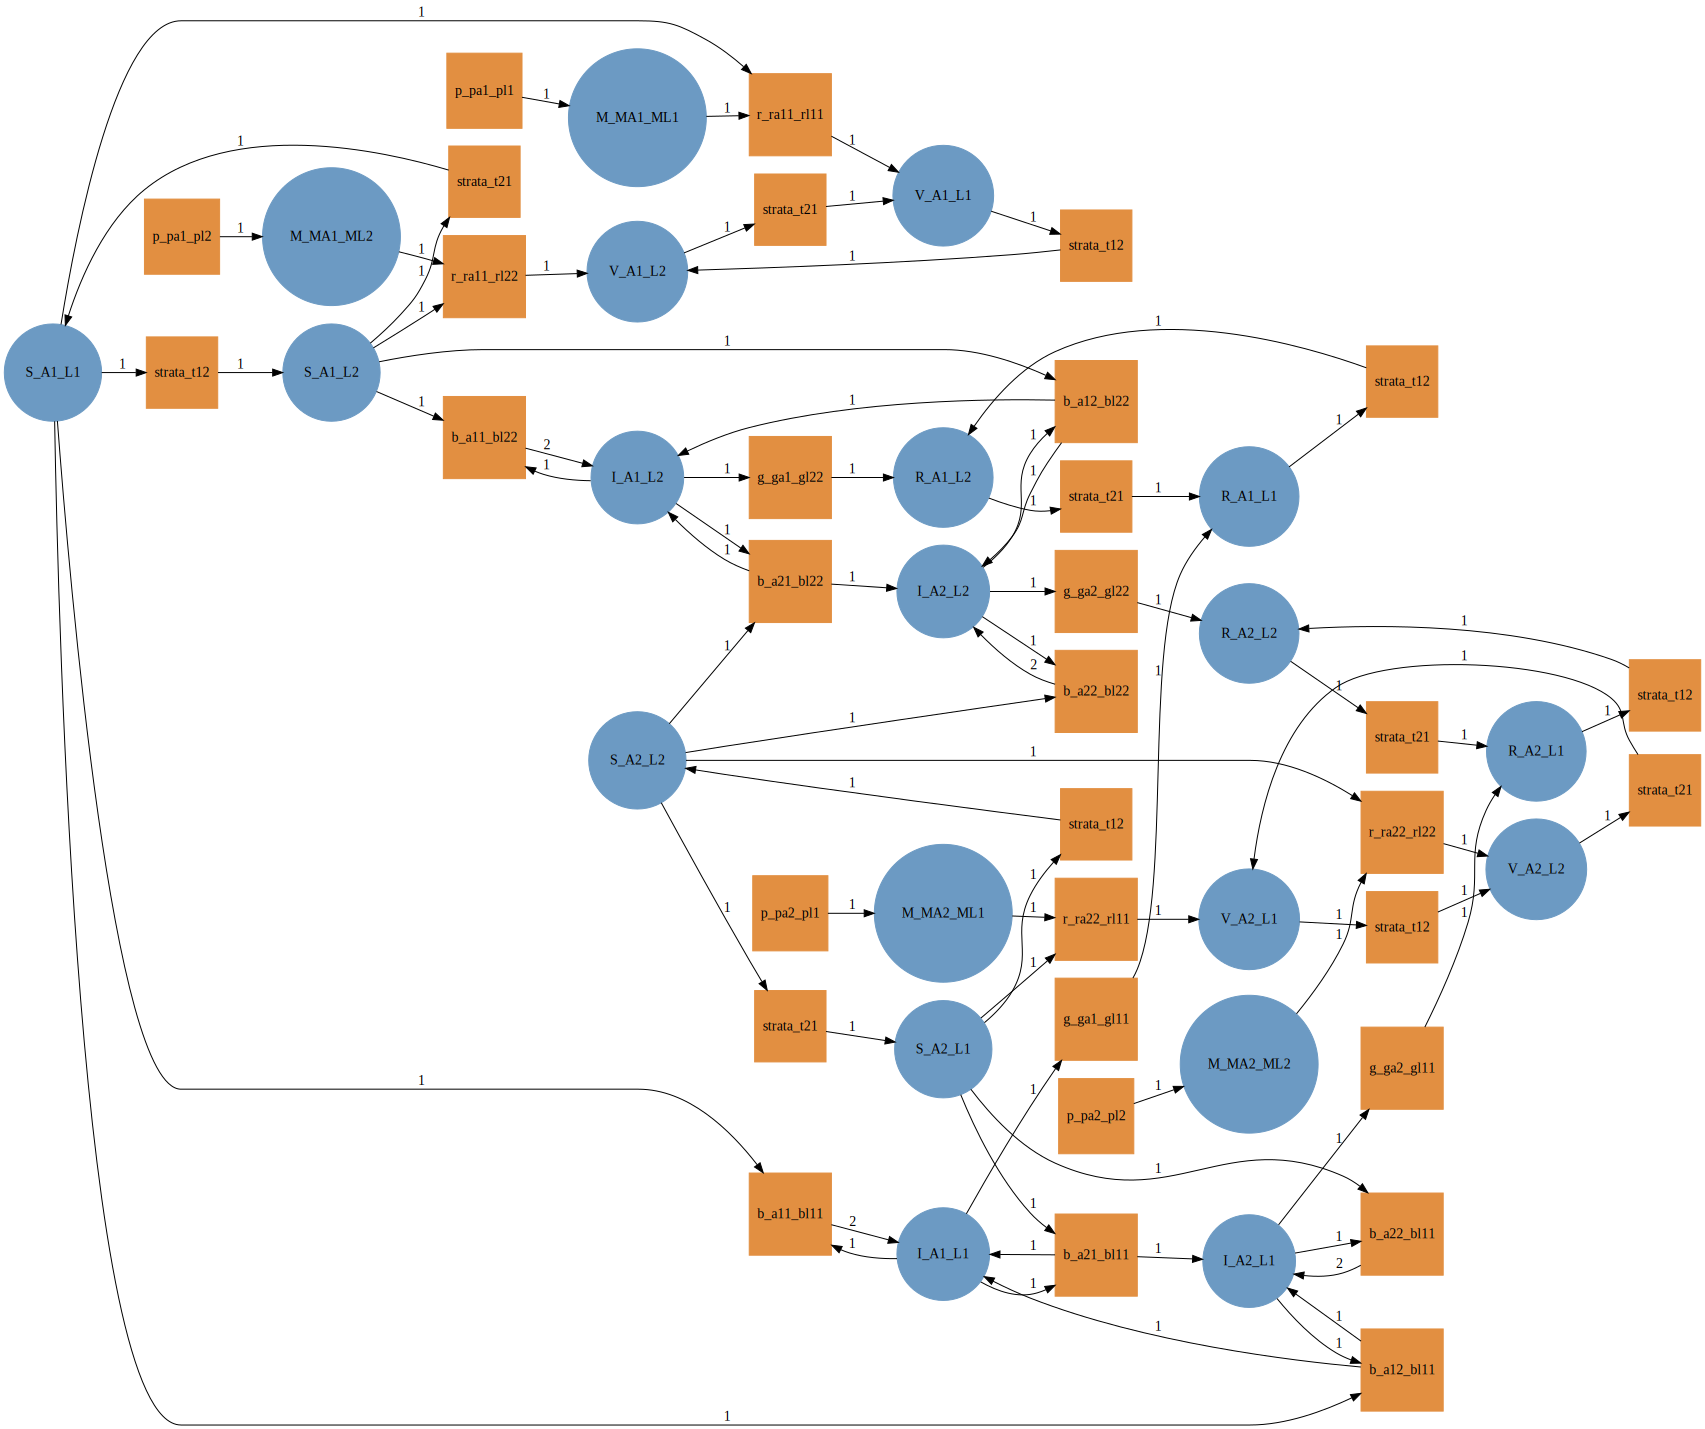

In [49]:
# Flatten labels to permit addition of reflexives
typed_sirv_agev_travelv_flat = flatten_labels(typed_sirv_agev_travelv)

Graph(dom(typed_sirv_agev_travelv_flat))

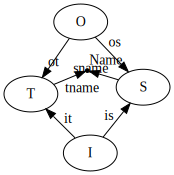

In [93]:
# ontology -?-> SchPetriNet
# to_graphviz(acset_schema(ontology))
to_graphviz(SchLabelledPetriNet)

In [172]:
write_json_acset(FreeDiagram(SchLabelledPetriNet), "test.json")

acset_name(LabelledPetriNet())
s = acset_schema(LabelledPetriNet())

s.homs
s.attrs
s.attrtypes
s.obs

s = acset_schema(LabelledPetriNet())
JSON3.write(s)

"{\"obs\":[\"T\",\"S\",\"I\",\"O\"],\"homs\":[[\"it\",\"I\",\"T\"],[\"is\",\"I\",\"S\"],[\"ot\",\"O\",\"T\"],[\"os\",\"O\",\"S\"]],\"attrtypes\":[\"Name\"],\"attrs\":[[\"tname\",\"T\",\"Name\"],[\"sname\",\"S\",\"Name\"]]}"